In [1]:
import gpjax as gpx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
import distrax as dx
import typing as tp
import jax.scipy.linalg as jsl

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2022-06-10 11:28:11.399201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
def plot_pdf(x: jnp.DeviceArray, dist: dx.Distribution) -> jnp.DeviceArray:
    return dist.prob(x)

In [3]:
def barycentre(dists: tp.List[dx.Distribution], weights: jnp.ndarray) -> dx.Distribution:
    means = jnp.stack([d.mean() for d in dists])
    variances = jnp.stack([d.variance() for d in dists])
    barycentre_mean = jnp.multiply(means, weights)
    barycentre_mean = barycentre_mean.squeeze()
    barycentre_mean = jnp.sum(barycentre_mean, axis = -1 , keepdims = True)

    gaussian_vars = variances.squeeze()
    barycentre_var = jnp.multiply(weights, jnp.sqrt(gaussian_vars))
    barycentre_var = jnp.square(jnp.sum(barycentre_var))
    return dx.Normal(barycentre_mean, jnp.sqrt(barycentre_var))

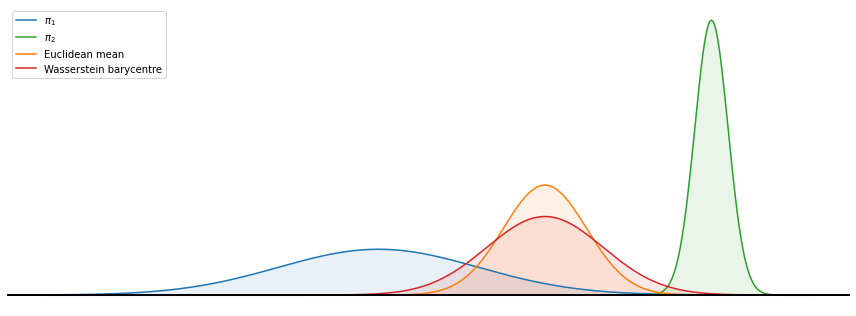

In [9]:
d1 = dx.Normal(loc = 10., scale=1.5)
d2 = dx.Normal(loc = 15., scale=0.25)


x = jnp.linspace(5., 16.5, 500)
pdf1 = plot_pdf(x, d1)
pdf2 = plot_pdf(x, d2)

euclidean_mean = jnp.mean(jnp.array([d1.mean(), d2.mean()]))
euclidean_scale = jnp.std(jnp.array([d1.scale, d2.scale]))
euclidean_dist = dx.Normal(loc=euclidean_mean, scale=euclidean_scale)
euclidean_pdf = plot_pdf(x, euclidean_dist)

wass_bary =barycentre([d1, d2], jnp.array([0.5, 0.5]))
wass_pdf = plot_pdf(x, wass_bary)

fig, ax = plt.subplots(figsize=(12, 4.5), tight_layout=True)
ax.plot(x, pdf1, label=r'$\pi_1$', color='tab:blue')
ax.plot(x, pdf2, label=r'$\pi_2$', color='tab:green')
ax.plot(x, euclidean_pdf, label='Euclidean mean', color='tab:orange')
ax.plot(x, wass_pdf, label='Wasserstein barycentre', color='tab:red')

ax.fill_between(x, jnp.zeros_like(pdf1), pdf1, color='tab:blue', alpha=0.1)
ax.fill_between(x, jnp.zeros_like(pdf2), pdf2, color='tab:green', alpha=0.1)
ax.fill_between(x, jnp.zeros_like(euclidean_pdf), euclidean_pdf, color='tab:orange', alpha=0.1)
ax.fill_between(x, jnp.zeros_like(wass_pdf), wass_pdf, color='tab:red', alpha=0.1)
ax.legend(loc='best')
ax.axhline(y=0., color='black', linewidth=2)
ax.axis('off')
plt.savefig('barycentre_fig.pdf')
plt.savefig('barycentre_fig.png', dpi=450)

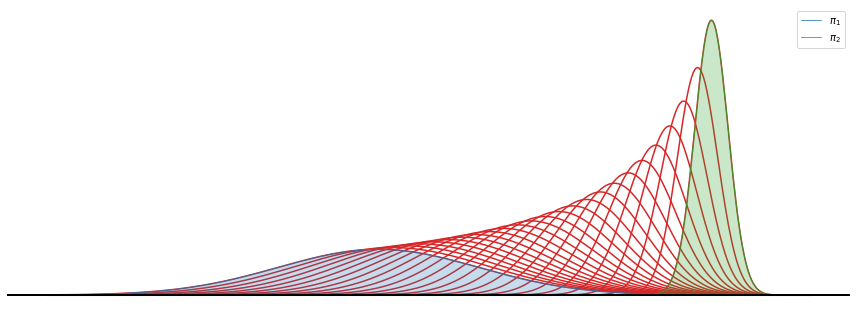

In [8]:
import ot

pdfs = []
for weight in jnp.linspace(0., 1., 25):
    alpha = weight 
    beta = 1. - weight
    weights = jnp.array([alpha, beta])
    wass_bary = barycentre([d1, d2], weights)
    pdfs.append(plot_pdf(x, wass_bary))

fig, ax = plt.subplots(figsize=(12, 4.5), tight_layout=True)
ax.plot(x, pdf1, label=r'$\pi_1$', color='tab:blue', linewidth=0.75, zorder=2)
ax.plot(x, pdf2, label=r'$\pi_2$', color='tab:green', linewidth=0.75, zorder=2)
ax.fill_between(x, jnp.zeros_like(pdf1), pdf1, color='tab:blue', alpha=0.25, zorder=2)
ax.fill_between(x, jnp.zeros_like(pdf2), pdf2, color='tab:green', alpha=0.25, zorder=2)

for pdf in pdfs:
    ax.plot(x, pdf, color='tab:red', zorder=1)
    # ax.fill_between(x, jnp.zeros_like(pdf), pdf, color='tab:red', alpha=0.02, zorder=1)
ax.legend(loc='best')
ax.axhline(y=0., color='black', linewidth=2)
ax.axis('off')

plt.savefig('barycentre_interpolant.pdf')
plt.savefig('barycentre_interpolant.png', dpi=450)